# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. 

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
} 

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel(r'''C:\Users\mia\Documents\Python Scripts\WineKMC.xlsx''', sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\mia\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [4]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel(r'''C:\Users\mia\Documents\Python Scripts\WineKMC.xlsx''', sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\mia\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [6]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [7]:
# Pivot the transaction dataframe, group the pivot table index by customer and column by offer ID 
# Fill NaNs with 0s
mydf = pd.pivot_table(data=df_transactions,index='customer_name',columns='offer_id',fill_value=0)

# Drop the level of the pivot table's column
mydf.columns = mydf.columns.droplevel()

# Rename the columns of the pivot table
mycols = []
for c in mydf.columns:
    mycols.append('offer'+str(c))
    
mydf.columns = mycols

# Reset the index of the pivot table, so that customer_name can be a column
mydf.reset_index(inplace=True)

mydf.head()

,customer_name,offer1,offer2,offer3,offer4,offer5,offer6,offer7,offer8,offer9,...,offer23,offer24,offer25,offer26,offer27,offer28,offer29,offer30,offer31,offer32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering  Choosing K:

I will try two methods to choose K: the Elbow method, the Silhouette method and the gap statistic.

###  The Elbow Sum-of-Squares Method

When we start to have diminishing returns on SS by increasing K, that SS value represents better clusterings. The idea is to have a small sum of squares error. However,SS here will just decrease to 0 when K is equal to the number of data points, and we dont want each point is its own cluster. Therefore, the point where SS begins to decrease slower, is a small enpugh error to represent better clustings.

Text(0.5,1,'The Elbow Method showing the optimal k')

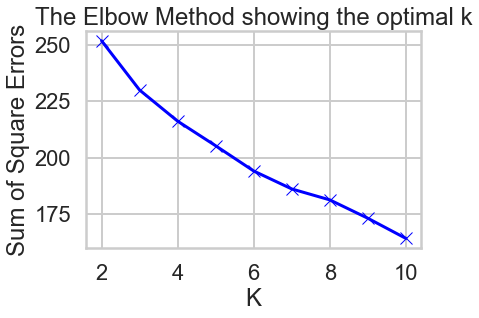

In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = mydf.iloc[:,1:]

# Create clusterings with K varying from 2 to 10
K = range(2,11)
Kmeans = [KMeans(n_clusters=i) for i in K]
# Get the SS of each clustering 
SS = [Kmeans[i].fit(x_cols).inertia_ for i in range(len(Kmeans))]

# Construct a plot showing  𝑆𝑆  for each  𝐾 
plt.plot(K,SS,'bx-')
plt.xlabel('K')
plt.ylabel('Sum of Square Errors')
plt.title('The Elbow Method showing the optimal k')

The optimal K is 3.

Text(0,0.5,'Customers in Each Cluster')

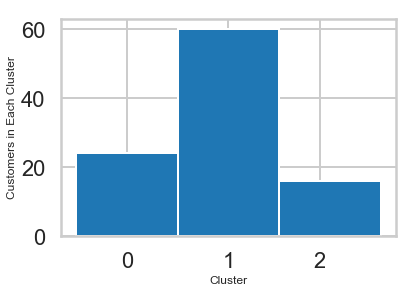

In [9]:
# Make a bar chart showing the number of points in each cluster for k-means under the best K, 3 .
best_cluster = Kmeans[1]
#mydf['cluster'] = best_cluster.fit_predict(x_cols)
plt.hist(best_cluster.fit_predict(x_cols),bins=3)
plt.xticks([0.333,1,1.6],(0,1,2))
plt.xlabel('Cluster',size='large')
plt.ylabel('Customers in Each Cluster',size='large')

### The Silhouette Method

For n_clusters=  2 , the average silhouette score is  0.07926723462002187
For n_clusters=  3 , the average silhouette score is  0.12133064283950247
For n_clusters=  4 , the average silhouette score is  0.1248746014478359
For n_clusters=  5 , the average silhouette score is  0.10791501300666746
For n_clusters=  6 , the average silhouette score is  0.11733032129346065
For n_clusters=  7 , the average silhouette score is  0.11360284656877549
For n_clusters=  8 , the average silhouette score is  0.131212262233451
For n_clusters=  9 , the average silhouette score is  0.13149725253044256
For n_clusters=  10 , the average silhouette score is  0.13057575826829818


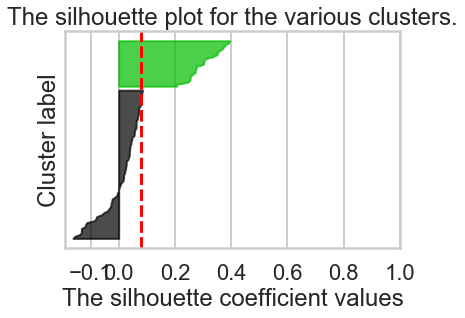

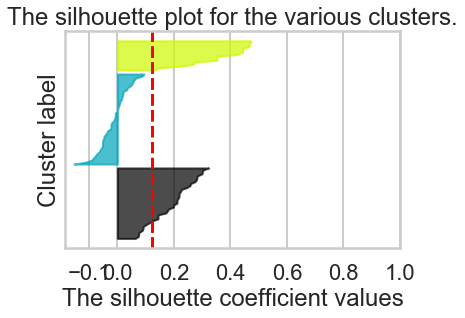

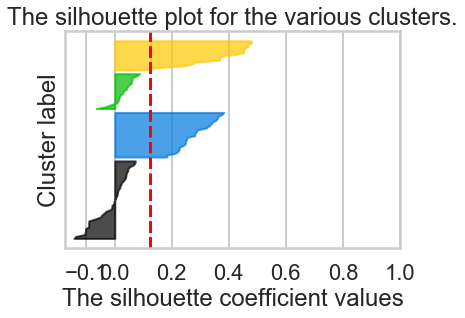

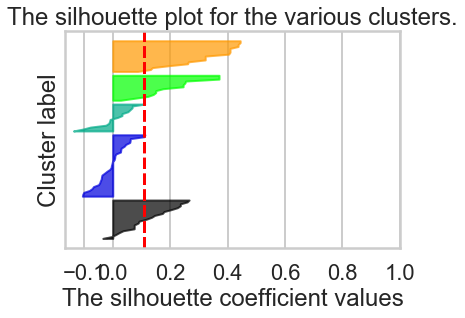

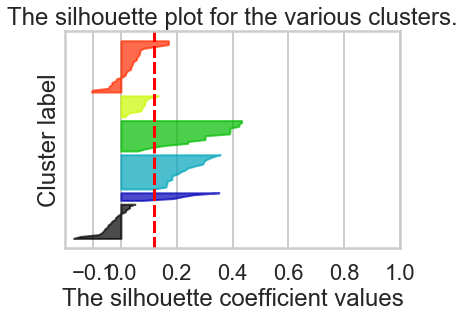

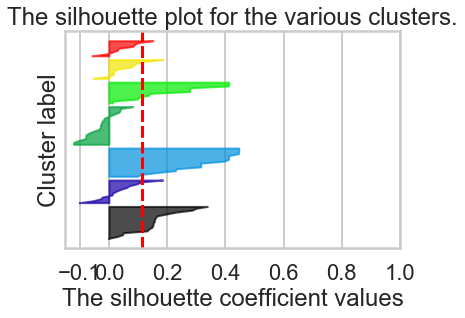

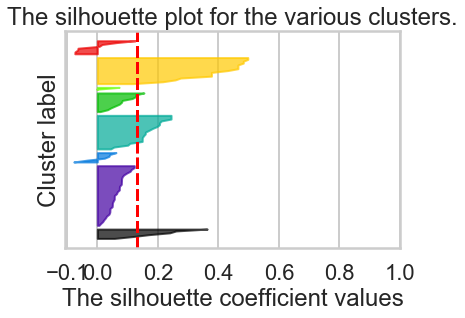

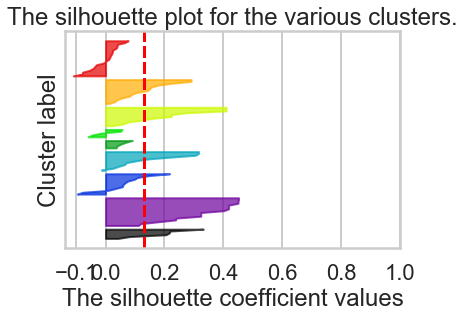

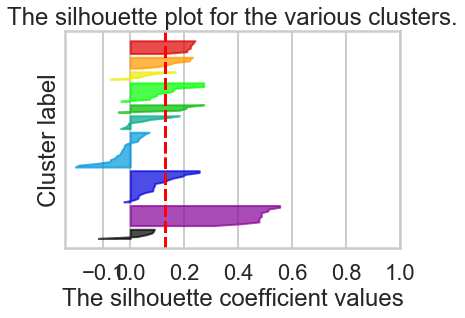

In [10]:
# Construct a series of silhouette plots and compute the average silhouette score for each $K$ and plot it.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

kranges = range(2,11)

for k in kranges:
    
    f, ax = plt.subplots()
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 8 for reproducibility.
    cluster = KMeans(n_clusters=k,random_state=8)
    labels = cluster.fit_predict(x_cols)
    
    silhouette_avg = silhouette_score(x_cols,labels)
    print('For n_clusters= ', k, ', the average silhouette score is ',
         silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols,labels)
    
    y_lower=10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels==i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower +size_cluster_i
        
        color = cm.nipy_spectral(float(i)/k)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
         # Compute the new y_lower for next plot
        y_lower = y_upper + 1  # 1 for the 0 samples
        
        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

According to the average silhouette score and the plots, the optimal K is 9. However, the avergae silhouette score is just 0.131 when K is 9, which indicates that no substantial structure has been found.

## Visualizing Clusters using PCA

In [11]:
# Reduce the dimensionality of the clustering data to 2 components
from sklearn.decomposition import PCA

df2 = pd.DataFrame(PCA(n_components=2).fit_transform(x_cols))
df2.columns = ['x','y']
df2['customer_name'] = mydf.customer_name

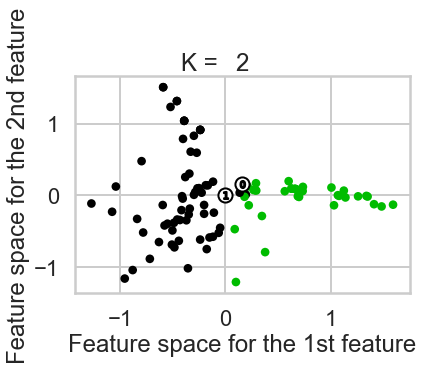

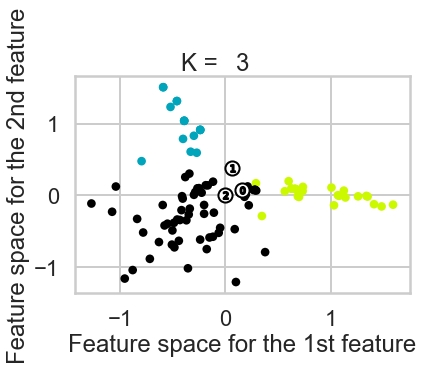

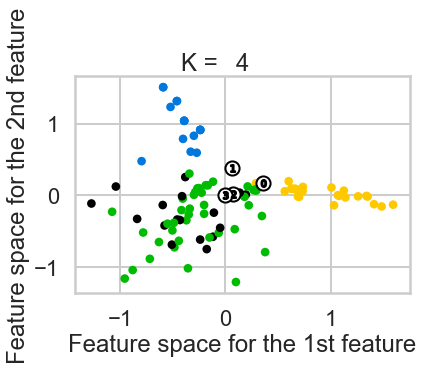

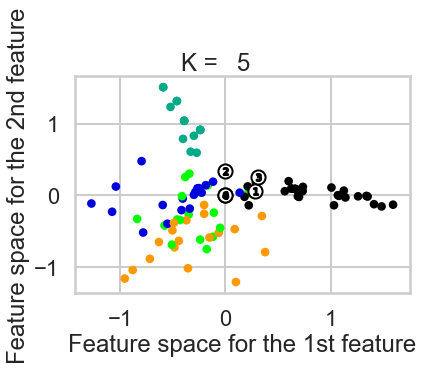

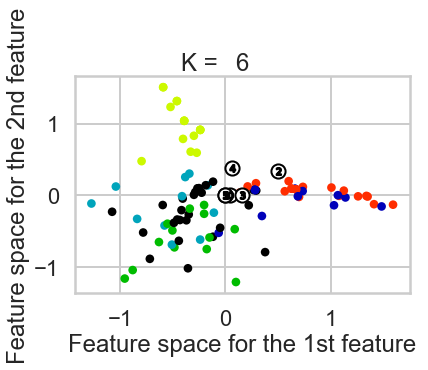

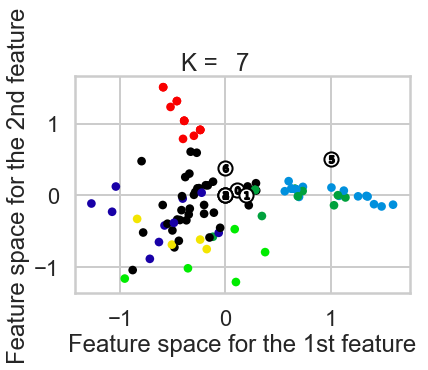

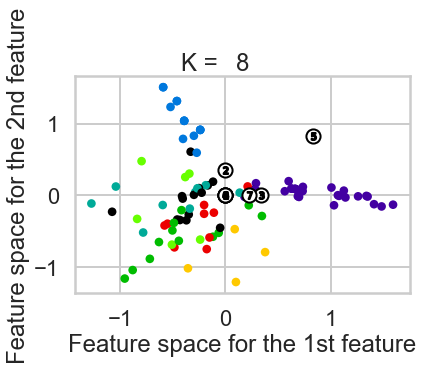

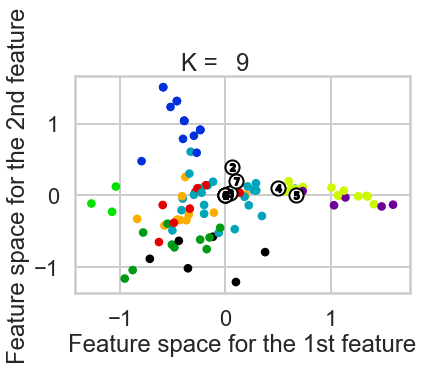

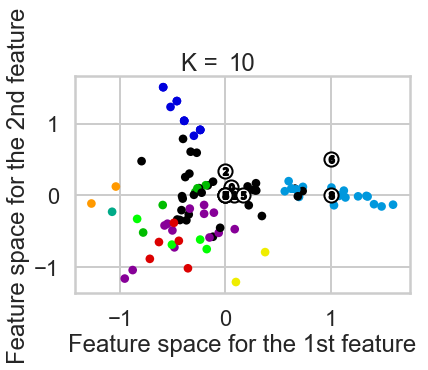

In [12]:
Kranges = range(2,11)


for k in Kranges:
    
    fig, ax = plt.subplots()
    
    cluster = KMeans(n_clusters=k)
    df2['labels'] = cluster.fit_predict(x_cols)
    
    colors = cm.nipy_spectral(df2.labels.astype(float)/k)
    ax.scatter(df2.x,df2.y,marker='.',s=300,lw=0, c=colors,edgecolor='k')
    
    # Labeling the clusters
    centers = cluster.cluster_centers_
    # Draw white circles at cluster centers
    ax.scatter(centers[:,0],centers[:,1],marker='o',c='white',s=200,edgecolor='k')
    
    for i,c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    ax.set_title('                K = ',loc='left')
    ax.set_title(k,loc='center')
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")


Visually, I think the optimal K is three. It divides the points well. This is exactly the optimal K provided by the Elbow method. When K increases to more than three, the clusters seem to be overlapped too much and no matte how large the K increases, the cluster centers seem always to be around (0,0).

######  Now look at both the original raw data about the offers and transactions and look at the fitted clusters. 

In [13]:
cluster = KMeans(n_clusters=3)
mydf['labels'] = cluster.fit_predict(x_cols)

In [14]:
customers_clusters = mydf[['customer_name','labels']]

In [15]:
df = pd.merge(df_transactions, customers_clusters)
df = pd.merge(df_offers, df)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,labels
0,1,January,Malbec,72,56,France,False,Thomas,1,1
1,1,January,Malbec,72,56,France,False,Jackson,1,1
2,1,January,Malbec,72,56,France,False,Mitchell,1,1
3,1,January,Malbec,72,56,France,False,Peterson,1,2
4,1,January,Malbec,72,56,France,False,Wood,1,1


In [16]:
# To display the result nicely, I convert the grouped results to a data frame.
pd.DataFrame(df.groupby('labels').varietal.value_counts())

varietal
labels varietal                    
0      Espumante                 32
       Prosecco                  20
       Malbec                    18
       Pinot Grigio              16
       Merlot                     7
       Champagne                  6
       Cabernet Sauvignon         2
       Chardonnay                 1
1      Champagne                 74
       Cabernet Sauvignon        30
       Prosecco                  21
       Chardonnay                13
       Malbec                    13
       Merlot                    12
       Espumante                  8
       Pinot Noir                 7
       Pinot Grigio               1
2      Pinot Noir                37
       Prosecco                   2
       Champagne                  1
       Chardonnay                 1
       Malbec                     1
       Merlot                     1

Most of the Champagne and Cabernet Sauvignon offers were purchase by members of cluster 0. Most of the Espumante offers were purchased by members of cluster 1. Most of the Pinot Noir offers were purchased by members from cluster 2. Prosecco offers were purchased equally by memebers of cluster 0 and 1.

In [17]:
pd.DataFrame(df.groupby('labels').campaign.value_counts())

campaign
labels campaign           
0      March            34
       December         18
       November         17
       July             14
       May               8
       April             3
       August            3
       February          2
       October           2
       June              1
1      August           28
       December         25
       February         20
       June             18
       March            17
       May              15
       October          15
       April            13
       January          13
       November          6
       July              5
       September         4
2      October          13
       September        13
       January           7
       July              7
       April             1
       June              1
       May               1

Most of the August campagin offers were purchased by members of cluster 0. Most of the March campagin offers were purchased by members of cluster 1.

In [18]:
df.groupby('labels')[['min_qty', 'discount','past_peak']].mean()

,min_qty,discount,past_peak
labels,,,
0,16.823529,55.647059,0.196078
1,80.379888,63.435754,0.206704
2,65.581395,52.116279,0.000000


Members in cluster 0 and 3 like to buy a large size of wine, members in cluster 2, on the other hand, intend to buy small volume. Memebers in cluster 3 do not have interest in wines past peak.

#### Finding the true optimal number of dimensions

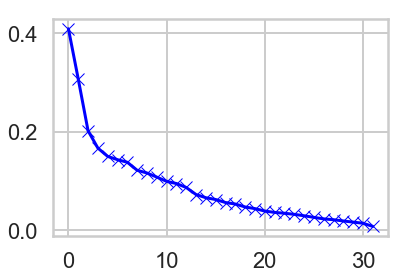

In [19]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.plot(pca.explained_variance_,'bx-')

The optimal K is 3, where the curve's slop slows sharply.

### Try clustering using other algorithms

###### Affinity propagation

Text(0.5,1,'Clusters by Affinity Propagration')

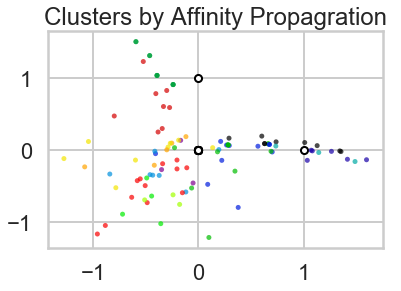

In [20]:
from sklearn.cluster import AffinityPropagation

fig, ax = plt.subplots()

cluster = AffinityPropagation()
labels = cluster.fit_predict(x_cols)

# Labeling the clusters
centers = cluster.cluster_centers_
# Draw white circles at cluster centers
ax.scatter(centers[:,0],centers[:,1],marker='o',c='white',s=50,edgecolor='k')

colors = cm.nipy_spectral(labels.astype(float)/len(np.unique(labels)))
ax.scatter(df2.x,df2.y,marker='.',s=100,lw=0, c=colors,edgecolor='k',alpha=0.7)

ax.set_title('Clusters by Affinity Propagration')

Only three unique centers are visiable -- (0,0), (0,1), (1,0),  but there are obviously more than three colors. 

In [21]:
from sklearn.cluster import SpectralClustering

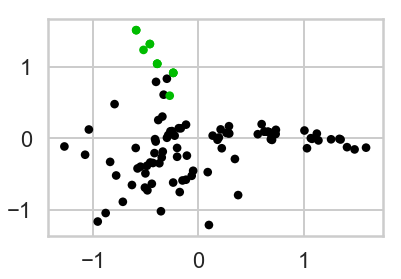

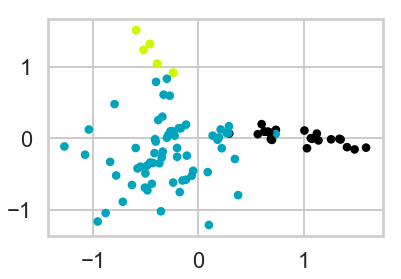

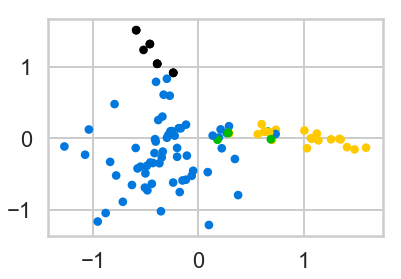

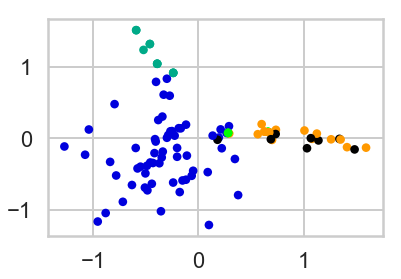

In [22]:
#Spectral Cluster works well for a small number of clusters but is not advised when using many clusters
clusters = range(2,6)
spectral_clusters = [SpectralClustering(n_clusters=n) for n in clusters]

for cluster in spectral_clusters:
    
    fig,ax = plt.subplots()
    
    labels = cluster.fit_predict(x_cols)
    
    colors = cm.nipy_spectral(labels.astype(float)/len(np.unique(labels)))
    ax.scatter(df2.x,df2.y,marker='.',s=300,lw=0, c=colors,edgecolor='k')

Visually, it is better to have three clusters.

Text(0.5,1,'Agglomerative Clustering')

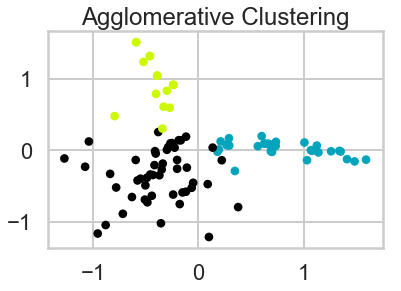

In [23]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_cluster = AgglomerativeClustering(n_clusters=3)

labels = agglomerative_cluster.fit_predict(x_cols)
    
colors = cm.nipy_spectral(labels.astype(float)/len(np.unique(labels)))
plt.scatter(df2.x,df2.y,marker='.',s=300,lw=0, c=colors,edgecolor='k')
plt.title('Agglomerative Clustering')

Text(0.5,1,'DBSCAN Clustering')

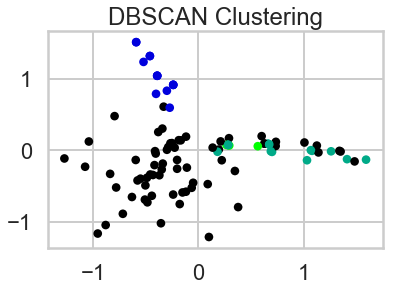

In [24]:
from sklearn.cluster import DBSCAN

dbscan_cluster = DBSCAN(eps=1)

labels = dbscan_cluster.fit_predict(x_cols)
    
colors = cm.nipy_spectral(labels.astype(float)/len(np.unique(labels)))
plt.scatter(df2.x,df2.y,marker='.',s=300,lw=0, c=colors,edgecolor='k')
plt.title('DBSCAN Clustering')

I think among above four clustering algorithms, Agglomerative Clustering has the best result. However, that is only becuse I knew 3 would be the best number of clusters and I knew it from the Elbow method to find the optimal K for K-Mean Clustering. Affinity Propagation turned out to have 14 labels but just three centers. The clusters on original data produced by Spectral clustering do not look as nice as the clusters produced by K-Mean, even if when the number of clusters is three. DBSCAN's result is the same with Spectral Clustering. Thus, I think K-Mean is the best clustering algorithm for this data set.